<a href="https://colab.research.google.com/github/ak2449/SNN-Project/blob/main/Radar_Training_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Simulate a basic object localization scenario by transmitting a pulse, simulating its reflection off a target at a given distance, and receiving the reflected pulse to estimate the target's distance based on the time of flight.

## Define parameters

### Subtask:
Define the parameters for the simulation, including the speed of the pulse (e.g., speed of light), the distance to the target, and the duration of the simulation.


**Reasoning**:
Define the parameters for the simulation as requested in the instructions.



In [ ]:
speed_of_pulse = 3e8  # Speed of light in m/s
distance_to_target = 1000  # Distance to the target in meters
simulation_duration = 2 * distance_to_target / speed_of_pulse * 2 # Simulation duration, ensuring enough time for round trip

## Simulate pulse transmission

### Subtask:
Simulate the transmission of a pulse from the source.


**Reasoning**:
Define the variable representing the time of pulse transmission, which is at the beginning of the simulation.



In [ ]:
transmission_time = 0  # Pulse transmitted at the beginning of the simulation

## Simulate pulse reflection

### Subtask:
Simulate the reflection of the pulse off the target.


**Reasoning**:
Calculate the time it takes for the pulse to reach the target and store it in a variable.



In [ ]:
time_of_arrival_at_target = transmission_time + distance_to_target / speed_of_pulse

## Simulate pulse reception

### Subtask:
Simulate the reception of the reflected pulse at the source.


**Reasoning**:
Calculate the reception time of the reflected pulse at the source using the previously defined variables.



In [ ]:
reception_time = transmission_time + 2 * (distance_to_target / speed_of_pulse)

## Calculate time of flight

### Subtask:
Calculate the time it takes for the pulse to travel to the target and back.


**Reasoning**:
Calculate the time of flight by subtracting the transmission time from the reception time and store it in a variable.



In [ ]:
time_of_flight = reception_time - transmission_time

## Estimate distance

### Subtask:
Estimate the distance to the target based on the time of flight and the speed of the pulse.


**Reasoning**:
Estimate the distance to the target based on the time of flight and the speed of the pulse by multiplying time_of_flight by the speed_of_pulse and dividing by 2, store the calculated estimated distance in a new variable called `estimated_distance`, and print the `estimated_distance` to verify the result.



In [ ]:
estimated_distance = (time_of_flight * speed_of_pulse) / 2
print(estimated_distance)

1000.0


## Summary:

### Data Analysis Key Findings

*   The simulation parameters were defined with the speed of the pulse set to \$3e8\$ m/s, the distance to the target set to 1000 meters, and a calculated simulation duration sufficient for the round trip.
*   The pulse transmission was simulated by setting the `transmission_time` to 0.
*   The pulse reflection was simulated by calculating the `time_of_arrival_at_target` as \$transmission\_time + distance\_to\_target / speed\_of\_pulse\$.
*   The reception of the reflected pulse was simulated by calculating the `reception_time` as \$transmission\_time + 2 * (distance\_to\_target / speed\_of\_pulse)\$.
*   The time of flight was calculated by subtracting the transmission time from the reception time: \$time\_of\_flight = reception\_time - transmission\_time\$.
*   The estimated distance to the target was calculated as \$(time\_of\_flight * speed\_of\_pulse) / 2\$, resulting in an estimated distance of 1000.0 meters.

### Insights or Next Steps

*   This simulation successfully demonstrates the principle of object localization using the time of flight method.
*   Future steps could involve adding noise to the time of flight measurement to simulate real-world conditions and evaluate the impact on distance estimation accuracy.



# FMCW Radar



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def awgn(signal, snr_db, measured='measured'):
    """
    Adds Additive White Gaussian Noise to a complex signal.

    Parameters:
    signal (np.array): Input complex signal.
    snr_db (float): Desired Signal-to-Noise Ratio in dB.
    measured (str): If 'measured', calculates signal power from the input.

    Returns:
    np.array: Signal with added noise.
    """
    if measured == 'measured':
        # Calculate signal power
        signal_power = np.mean(np.abs(signal)**2)
    else:
        # This case is not in the original code, but good practice
        # Assumes signal power is 1 if not 'measured'
        signal_power = 1.0

    # Convert SNR from dB to linear
    snr_linear = 10**(snr_db / 10.0)

    # Calculate noise power
    noise_power = signal_power / snr_linear

    # Calculate noise standard deviation (for complex noise)
    # Complex noise power is sum of real and imag variances (var_real + var_imag)
    # Assuming var_real = var_imag = noise_power / 2
    noise_std_dev = np.sqrt(noise_power / 2.0)

    # Generate complex Gaussian noise
    noise = (np.random.normal(0, noise_std_dev, signal.shape) +
             1j * np.random.normal(0, noise_std_dev, signal.shape))

    return signal + noise


In [ ]:
# --- Parameters ---
c = 3e8                        # Speed of light (m/s)
fc = 77e9                      # Carrier frequency (Hz)
lambda_ = c / fc               # Wavelength (m) (using lambda_ as 'lambda' is a Python keyword)

# --- Chirp parameters ---
bw = 150e6                     # Bandwidth
T_chirp = 10e-6                # Chirp duration (s)
k = bw / T_chirp               # Chirp rate (slope)
fs = 2 * bw                    # Sample rate (Hz)

# --- Frame parameters for velocity ---
n_chirps = 64                  # Number of chirps in a frame
T_frame = T_chirp * n_chirps   # Total frame time

# --- Scenario parameters ---
target_range = np.array([200, 75,  50])     # Target initial ranges (m)
target_vel = np.array([20,  -15, 10])       # Target velocities (m/s)
target_rcs = np.array([10,   0.8, 0.5])     # Radar Cross Section
n_targets = len(target_range)               # Number of targets

# --- Generate Tx ---
t = np.arange(0, T_chirp, 1/fs)     # Time vector for ONE chirp
n_samples = len(t)                  # Number of samples per chirp

tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase)


In [ ]:
# --- Simulate Chirp Frame ---
Mix_matrix = np.zeros((n_chirps, n_samples), dtype=complex)

for i in range(n_chirps): # Loop for each chirp (0 to n_chirps-1)

    Rx_total = np.zeros(n_samples, dtype=complex)
    time_at_chirp_start = i * T_chirp  # (i-1) in MATLAB becomes 'i' in 0-indexed Python

    # iterate through each target
    for j in range(n_targets):

        # Get this target's properties
        r0 = target_range[j]
        v0 = target_vel[j]

        # Calculate this target's current range
        current_range = r0 + v0 * time_at_chirp_start

        # Calculate time delay for this target
        tau = (2 * current_range) / c

        # Create the delayed time vector
        t_rx = t - tau

        # Generate this target's reflected signal phase
        rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
        Rx_j = np.exp(1j * rx_phase)

        # Apply attenuation based on range and RCS
        att = target_rcs[j] / (current_range**4)

        # Add this target's signal to the total
        Rx_total = Rx_total + (att * Rx_j)

    # Add noise
    Rx_noisy = awgn(Rx_total, 10, 'measured')

    # Mix the total received signal with the transmitted
    Mix_matrix[i, :] = Tx * np.conj(Rx_noisy)

Detected STRONGEST target at:
  Range:    49.80 m
  Velocity: 10.82 m/s


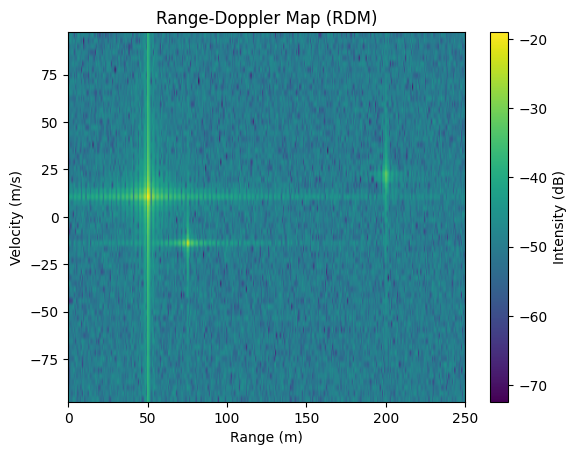

In [ ]:
# --- Process the Signal (2D FFT) ---

# Equivalent of 2^nextpow2(n)
n_fft_range = int(2**np.ceil(np.log2(n_samples)))
range_fft = np.fft.fft(Mix_matrix, n_fft_range, axis=1) # FFT along rows (axis=1)

n_fft_vel = int(2**np.ceil(np.log2(n_chirps)))
# FFT along columns (axis=0), then shift
rdm = np.fft.fftshift(np.fft.fft(range_fft, n_fft_vel, axis=0), axes=0)

# --- Create Axes for Plotting ---
f_beat_axis = fs * np.arange(n_fft_range/2 + 1) / n_fft_range
range_axis = (f_beat_axis * c) / (2 * k)

fs_doppler = 1 / T_chirp
doppler_freq_axis = np.linspace(-fs_doppler/2, fs_doppler/2, n_fft_vel)
vel_axis = (doppler_freq_axis * lambda_) / 2

# --- Visualize the Range-Doppler Map (RDM) ---
plt.figure()

# Select the first half of the range-FFT results
rdm_plot = np.abs(rdm[:, :n_fft_range//2 + 1])
rdm_db = 10 * np.log10(rdm_plot)

# Use imshow to plot. 'extent' maps data to axes. 'origin' matches MATLAB's 'axis xy'.
plt.imshow(rdm_db,
           extent=[range_axis[0], range_axis[-1], vel_axis[0], vel_axis[-1]],
           aspect='auto',
           origin='lower')

plt.title('Range-Doppler Map (RDM)')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Intensity (dB)')
plt.xlim(0, 250)

# --- Find the Peak - only finds strongest target ---
max_val = np.max(rdm_plot)
max_idx_flat = np.argmax(rdm_plot)

# np.unravel_index is the equivalent of ind2sub
# Note: It returns (row_idx, col_idx) which corresponds to (vel_idx, range_idx)
vel_idx, range_idx = np.unravel_index(max_idx_flat, rdm_plot.shape)

print('Detected STRONGEST target at:')
print(f'  Range:    {range_axis[range_idx]:.2f} m')
print(f'  Velocity: {vel_axis[vel_idx]:.2f} m/s')

# Display the plot
plt.show()



# FMCW Training Set


Generating 100 training samples...
  ... generated 100/100
Done! Generation took 5.52 seconds.

--- Final Dataset Shapes ---
X_data shape: (100, 64, 2049, 1)
y_data shape: (100, 64, 2049, 1)

Plotting one random sample for verification...


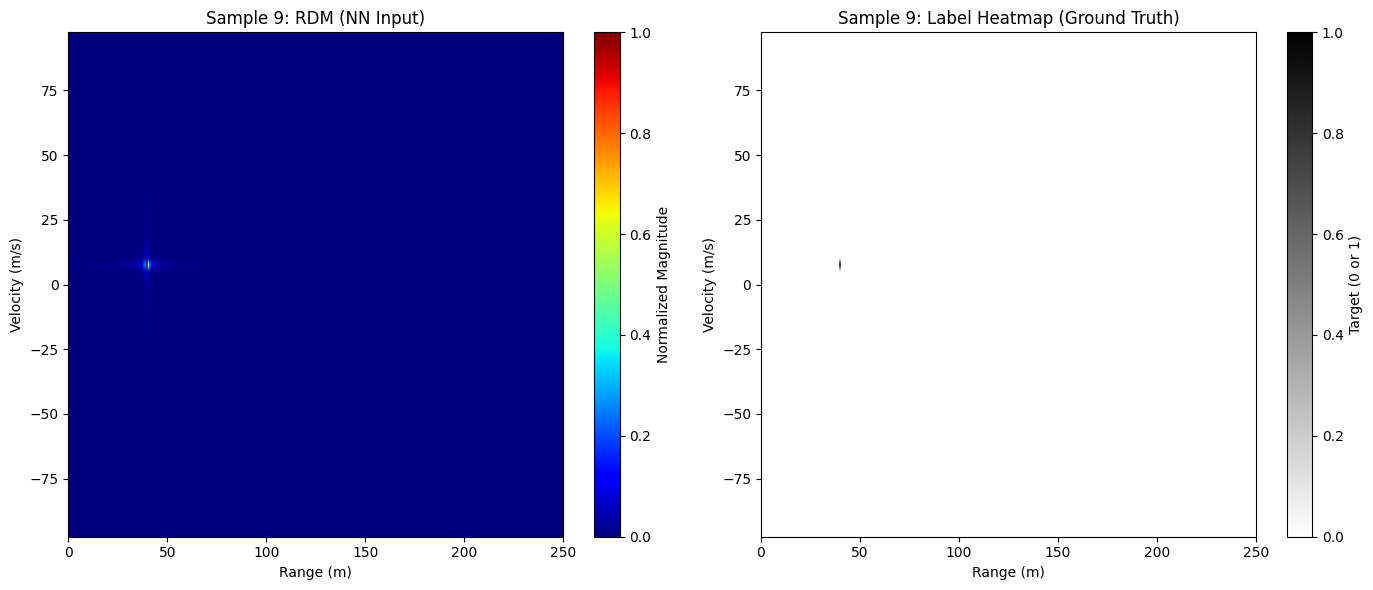

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time # Optional, to time generation

# --- Helper Function for AWGN ---
def awgn(signal, snr_db, measured='measured'):
    """
    Adds Additive White Gaussian Noise to a complex signal.
    """
    if measured == 'measured':
        signal_power = np.mean(np.abs(signal)**2)
    else:
        signal_power = 1.0

    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_std_dev = np.sqrt(noise_power / 2.0)

    noise = (np.random.normal(0, noise_std_dev, signal.shape) +
             1j * np.random.normal(0, noise_std_dev, signal.shape))

    return signal + noise

# --- Main Data Generation Function ---

def generate_single_sample(sim_params, rand_params, axes):
    """
    Generates a single randomized RDM and its corresponding label heatmap.

    Parameters:
    sim_params (dict): Dictionary of fixed simulation parameters (Tx, t, etc.)
    rand_params (dict): Dictionary of randomization bounds (range_lims, etc.)
    axes (dict): Dictionary with pre-calculated range_axis and vel_axis

    Returns:
    tuple: (normalized_rdm, label_heatmap)
    """

    # Unpack fixed simulation parameters
    Tx = sim_params['Tx']
    t = sim_params['t']
    n_samples = sim_params['n_samples']
    n_chirps = sim_params['n_chirps']
    T_chirp = sim_params['T_chirp']
    fc = sim_params['fc']
    k = sim_params['k']
    c = sim_params['c']
    n_fft_range = sim_params['n_fft_range']
    n_fft_vel = sim_params['n_fft_vel']

    # Unpack pre-calculated axes
    range_axis = axes['range_axis']
    vel_axis = axes['vel_axis']

    # --- 1. Randomize Scenario ---
    n_targets = np.random.randint(rand_params['n_targets_lims'][0],
                                  rand_params['n_targets_lims'][1] + 1)

    target_range = np.random.uniform(rand_params['range_lims'][0],
                                     rand_params['range_lims'][1], n_targets)

    target_vel = np.random.uniform(rand_params['vel_lims'][0],
                                   rand_params['vel_lims'][1], n_targets)

    target_rcs = np.random.uniform(rand_params['rcs_lims'][0],
                                   rand_params['rcs_lims'][1], n_targets)

    snr_db = np.random.uniform(rand_params['snr_lims'][0],
                               rand_params['snr_lims'][1])

    # --- 2. Simulate Chirp Frame ---
    Mix_matrix = np.zeros((n_chirps, n_samples), dtype=complex)

    for i in range(n_chirps): # Loop for each chirp
        Rx_total = np.zeros(n_samples, dtype=complex)
        time_at_chirp_start = i * T_chirp

        for j in range(n_targets): # iterate through each target
            r0 = target_range[j]
            v0 = target_vel[j]

            current_range = r0 + v0 * time_at_chirp_start
            tau = (2 * current_range) / c
            t_rx = t - tau

            rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
            Rx_j = np.exp(1j * rx_phase)

            att = target_rcs[j] / (current_range**4)
            Rx_total = Rx_total + (att * Rx_j)

        Rx_noisy = awgn(Rx_total, snr_db, 'measured')
        Mix_matrix[i, :] = Tx * np.conj(Rx_noisy)

    # --- 3. Process the Signal (2D FFT) ---
    range_fft = np.fft.fft(Mix_matrix, n_fft_range, axis=1)
    rdm = np.fft.fftshift(np.fft.fft(range_fft, n_fft_vel, axis=0), axes=0)

    # --- 4. Create RDM for NN Input (Magnitude + Normalize) ---
    # Take magnitude and select the first half of the range-FFT results
    rdm_mag = np.abs(rdm[:, :len(range_axis)])

    # Normalize to [0, 1]
    min_val = np.min(rdm_mag)
    max_val = np.max(rdm_mag)
    if max_val > min_val:
        rdm_normalized = (rdm_mag - min_val) / (max_val - min_val)
    else:
        rdm_normalized = np.zeros(rdm_mag.shape) # Handle zero-signal case

    # --- 5. Create Label Heatmap ---
    label_heatmap = np.zeros(rdm_normalized.shape)

    for j in range(n_targets):
        # Find the closest index in the axes for each target
        range_idx = np.argmin(np.abs(range_axis - target_range[j]))
        vel_idx = np.argmin(np.abs(vel_axis - target_vel[j]))

        # Set the corresponding pixel in the heatmap to 1
        # Ensure indices are within bounds (can happen at edges)
        if 0 <= vel_idx < label_heatmap.shape[0] and 0 <= range_idx < label_heatmap.shape[1]:
            label_heatmap[vel_idx, range_idx] = 1.0

    return rdm_normalized, label_heatmap

# =============================================================================
# --- MAIN SCRIPT ---
# =============================================================================

# --- 1. Define Fixed Simulation Parameters ---
c = 3e8
fc = 77e9
lambda_ = c / fc
bw = 150e6
T_chirp = 10e-6
k = bw / T_chirp
fs = 2 * bw
n_chirps = 64
t = np.arange(0, T_chirp, 1/fs)
n_samples = len(t)
tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase)
n_fft_range = int(2**np.ceil(np.log2(n_samples)))
n_fft_vel = int(2**np.ceil(np.log2(n_chirps)))

# Pack fixed parameters into a dictionary
sim_params = {
    'Tx': Tx, 't': t, 'n_samples': n_samples, 'n_chirps': n_chirps,
    'T_chirp': T_chirp, 'fc': fc, 'k': k, 'c': c,
    'n_fft_range': n_fft_range, 'n_fft_vel': n_fft_vel
}

# --- 2. Define Randomization Parameters ---
rand_params = {
    'n_targets_lims': (1, 4),        # Min/Max number of targets
    'range_lims':     (20, 200),     # Min/Max range (m)
    'vel_lims':       (-25, 25),     # Min/Max velocity (m/s)
    'rcs_lims':       (0.5, 10.0),   # Min/Max RCS
    'snr_lims':       (5, 25)        # Min/Max SNR (dB)
}

# --- 3. Pre-calculate Axes (constant for all samples) ---
f_beat_axis = fs * np.arange(n_fft_range/2 + 1) / n_fft_range
range_axis = (f_beat_axis * c) / (2 * k)

fs_doppler = 1 / T_chirp
doppler_freq_axis = np.linspace(-fs_doppler/2, fs_doppler/2, n_fft_vel)
vel_axis = (doppler_freq_axis * lambda_) / 2

axes = {'range_axis': range_axis, 'vel_axis': vel_axis}

# --- 4. Generate the Dataset ---
N_SAMPLES = 100 # Number of training samples to generate

print(f"Generating {N_SAMPLES} training samples...")

# Initialize lists to store the data
X_data_list = []
y_data_list = []

start_time = time.time()
for i in range(N_SAMPLES):
    rdm_norm, label_map = generate_single_sample(sim_params, rand_params, axes)

    X_data_list.append(rdm_norm)
    y_data_list.append(label_map)

    if (i+1) % 100 == 0:
        print(f"  ... generated {i+1}/{N_SAMPLES}")

end_time = time.time()
print(f"Done! Generation took {end_time - start_time:.2f} seconds.")

# --- 5. Convert to NumPy Arrays and Shape for NN ---
# Stack into a single large array
X_data = np.array(X_data_list)
y_data = np.array(y_data_list)

# Add a "channel" dimension at the end (for Keras/TensorFlow compatibility)
# Shape will be (N_SAMPLES, n_fft_vel, n_range_bins, 1)
X_data = X_data[..., np.newaxis]
y_data = y_data[..., np.newaxis]

print("\n--- Final Dataset Shapes ---")
print(f"X_data shape: {X_data.shape}")
print(f"y_data shape: {y_data.shape}")

# --- 6. Verification: Plot a random sample ---
print("\nPlotting one random sample for verification...")

idx_to_check = np.random.randint(0, N_SAMPLES)

plt.figure(figsize=(14, 6))

# Plot the RDM (NN Input)
plt.subplot(1, 2, 1)
plt.imshow(X_data[idx_to_check, :, :, 0],
           extent=[range_axis[0], range_axis[-1], vel_axis[0], vel_axis[-1]],
           aspect='auto',
           origin='lower',
           cmap='jet')
plt.title(f'Sample {idx_to_check}: RDM (NN Input)')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Normalized Magnitude')
plt.xlim(0, 250)

# Plot the Label (NN Target)
plt.subplot(1, 2, 2)
plt.imshow(y_data[idx_to_check, :, :, 0],
           extent=[range_axis[0], range_axis[-1], vel_axis[0], vel_axis[-1]],
           aspect='auto',
           origin='lower',
           cmap='gray_r')
plt.title(f'Sample {idx_to_check}: Label Heatmap (Ground Truth)')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Target (0 or 1)')
plt.xlim(0, 250)

plt.tight_layout()
plt.show()

# FMCW Training Custom


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
def awgn(signal, snr_db, measured='measured'):
    """
    Adds Additive White Gaussian Noise to a complex signal.
    """
    if measured == 'measured':
        signal_power = np.mean(np.abs(signal)**2)
    else:
        signal_power = 1.0

    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_std_dev = np.sqrt(noise_power / 2.0)

    noise = (np.random.normal(0, noise_std_dev, signal.shape) +
             1j * np.random.normal(0, noise_std_dev, signal.shape))

    return signal + noise

In [ ]:
def generate_single_sample(sim_params, rand_params, axes):
    """
    Generates a single randomized RDM and its corresponding label heatmap.

    Parameters:
    sim_params (dict): Dictionary of fixed simulation parameters (Tx, t, etc.)
    rand_params (dict): Dictionary of randomization bounds (range_lims, etc.)
    axes (dict): Dictionary with pre-calculated range_axis and vel_axis

    Returns:
    tuple: (normalized_rdm, label_heatmap)
    """

    # Unpack fixed simulation parameters
    Tx = sim_params['Tx']
    t = sim_params['t']
    n_samples = sim_params['n_samples']
    n_chirps = sim_params['n_chirps']
    T_chirp = sim_params['T_chirp']
    fc = sim_params['fc']
    k = sim_params['k']
    c = sim_params['c']
    n_fft_range = sim_params['n_fft_range']
    n_fft_vel = sim_params['n_fft_vel']

    # Unpack pre-calculated axes
    range_axis = axes['range_axis']
    vel_axis = axes['vel_axis']

    # --- 1. Randomize Scenario ---
    # n_targets = np.random.randint(rand_params['n_targets_lims'][0],
                                  # rand_params['n_targets_lims'][1] + 1)
    n_targets = 3

    target_range = np.random.uniform(rand_params['range_lims'][0],
                                     rand_params['range_lims'][1], n_targets)

    target_vel = np.random.uniform(rand_params['vel_lims'][0],
                                   rand_params['vel_lims'][1], n_targets)

    labels_range_velocity = [target_range,target_vel]


    target_rcs = np.random.uniform(rand_params['rcs_lims'][0],
                                   rand_params['rcs_lims'][1], n_targets)

    snr_db = np.random.uniform(rand_params['snr_lims'][0],
                               rand_params['snr_lims'][1])

    # --- 2. Simulate Chirp Frame ---
    Mix_matrix = np.zeros((n_chirps, n_samples), dtype=complex)

    for i in range(n_chirps): # Loop for each chirp
        Rx_total = np.zeros(n_samples, dtype=complex)
        time_at_chirp_start = i * T_chirp

        for j in range(n_targets): # iterate through each target
            r0 = target_range[j]
            v0 = target_vel[j]

            current_range = r0 + v0 * time_at_chirp_start
            tau = (2 * current_range) / c
            t_rx = t - tau

            rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
            Rx_j = np.exp(1j*rx_phase)

            att = target_rcs[j] / (current_range**4)
            Rx_total = Rx_total + (att * Rx_j)

        Rx_noisy = awgn(Rx_total, snr_db, 'measured')
        Mix_matrix[i, :] = Tx * np.conj(Rx_noisy)

    return Mix_matrix, labels_range_velocity

In [ ]:
def create_rdm(Mix_matrix, n_fft_range, n_fft_vel, range_axis, vel_axis):
    # --- 3. Process the Signal (2D FFT) ---
    range_fft = np.fft.fft(Mix_matrix, n_fft_range, axis=1)
    rdm = np.fft.fftshift(np.fft.fft(range_fft, n_fft_vel, axis=0), axes=0)

    # --- 4. Create RDM for NN Input (Magnitude + Normalize) ---
    # Take magnitude and select the first half of the range-FFT results
    rdm_mag = np.abs(rdm[:, :len(range_axis)])

    rdm_db = 10 * np.log10(rdm_mag)

    return rdm_db


Generating 10 training samples...
Done! Generation took 0.52 seconds.

--- Final Dataset Shapes ---
X_data shape: (10, 64, 3000, 1)
y_data shape: (10, 2, 3, 1)

Plotting one random sample for verification...


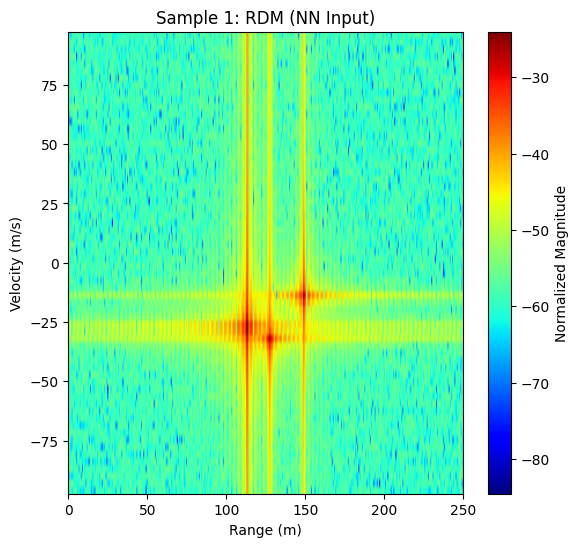

label data is [[127.45841022 148.88593196 113.2170183 ]
 [-34.06927841 -15.96690051 -28.77434437]]
mix_mat [[ 1.11952796e-08-3.13667104e-08j  1.96577669e-08-3.33437648e-08j
   2.10839714e-08-2.87214792e-08j ... -7.88837516e-09-2.70140884e-08j
  -3.71794201e-09-2.71028904e-08j  4.57777604e-09-2.95920970e-08j]
 [-1.15258689e-08-3.92126974e-08j -3.46964554e-09-3.70878839e-08j
   3.11180828e-09-3.59879322e-08j ... -3.12906261e-08-1.22702075e-08j
  -2.76053992e-08-1.33535369e-08j -1.79671986e-08-2.43008291e-08j]
 [-4.16617981e-08-2.09314790e-08j -3.16628802e-08-3.48807333e-08j
  -2.32341471e-08-3.70983372e-08j ... -3.05224842e-08+1.59034812e-08j
  -3.41937694e-08+8.24122489e-09j -3.62592745e-08-3.07027164e-09j]
 ...
 [-1.26669897e-08-6.40889719e-08j  6.91121531e-09-6.05478576e-08j
   2.10362316e-08-6.31040628e-08j ...  2.19749760e-08-3.43112766e-08j
   2.80686016e-08-2.77918337e-08j  3.49489539e-08-2.00041127e-08j]
 [-4.95978443e-08-3.24559382e-08j -4.41445364e-08-4.21875852e-08j
  -2.84505

In [ ]:
# --- MAIN SCRIPT ---
# =============================================================================

# --- 1. Define Fixed Simulation Parameters ---
c = 3e8
fc = 77e9
lambda_ = c / fc
bw = 150e6
T_chirp = 10e-6
k = bw / T_chirp
fs = 2 * bw
n_chirps = 64
t = np.arange(0, T_chirp, 1/fs)
n_samples = len(t)
tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase)
n_fft_range = int(2**np.ceil(np.log2(n_samples)))
n_fft_vel = int(2**np.ceil(np.log2(n_chirps)))

# Pack fixed parameters into a dictionary
sim_params = {
    'Tx': Tx, 't': t, 'n_samples': n_samples, 'n_chirps': n_chirps,
    'T_chirp': T_chirp, 'fc': fc, 'k': k, 'c': c,
    'n_fft_range': n_fft_range, 'n_fft_vel': n_fft_vel
}

# --- 2. Define Randomization Parameters ---
rand_params = {
    'n_targets_lims': (1, 4),        # Min/Max number of targets
    'range_lims':     (10, 200),     # Min/Max range (m)
    'vel_lims':       (-40, 40),     # Min/Max velocity (m/s)
    'rcs_lims':       (1.0, 10.0),   # Min/Max RCS
    'snr_lims':       (5, 25)        # Min/Max SNR (dB)
}

# --- 3. Pre-calculate Axes (constant for all samples) ---
f_beat_axis = fs * np.arange(n_fft_range/2 + 1) / n_fft_range
range_axis = (f_beat_axis * c) / (2 * k)

fs_doppler = 1 / T_chirp
doppler_freq_axis = np.linspace(-fs_doppler/2, fs_doppler/2, n_fft_vel)
vel_axis = (doppler_freq_axis * lambda_) / 2

axes = {'range_axis': range_axis, 'vel_axis': vel_axis}

# --- 4. Generate the Dataset ---
N_SAMPLES = 10 # Number of training samples to generate

print(f"Generating {N_SAMPLES} training samples...")

# Initialize lists to store the data
X_data_list = []
y_data_list = []

start_time = time.time()
for i in range(N_SAMPLES):
    mix_mat, labels = generate_single_sample(sim_params, rand_params, axes)

    X_data_list.append(mix_mat)
    y_data_list.append(labels)

    if (i+1) % 100 == 0:
        print(f"  ... generated {i+1}/{N_SAMPLES}")

end_time = time.time()
print(f"Done! Generation took {end_time - start_time:.2f} seconds.")

# --- 5. Convert to NumPy Arrays and Shape for NN ---
# Stack into a single large array
X_data = np.array(X_data_list)
y_data = np.array(y_data_list)

# Add a "channel" dimension at the end (for Keras/TensorFlow compatibility)
# Shape will be (N_SAMPLES, n_fft_vel, n_range_bins, 1)
X_data = X_data[..., np.newaxis]
y_data = y_data[..., np.newaxis]

print("\n--- Final Dataset Shapes ---")
print(f"X_data shape: {X_data.shape}")
print(f"y_data shape: {y_data.shape}")

# --- 6. Verification: Plot a random sample ---
print("\nPlotting one random sample for verification...")

idx_to_check = np.random.randint(0, N_SAMPLES)

plt.figure(figsize=(14, 6))
rdm_normalized = create_rdm(X_data[idx_to_check, :, :, 0], n_fft_range, n_fft_vel, range_axis, vel_axis)
# Plot the RDM (NN Input)
plt.subplot(1, 2, 1)

plt.imshow(rdm_normalized,
           extent=[range_axis[0], range_axis[-1], vel_axis[0], vel_axis[-1]],
           aspect='auto',
           origin='lower',
           cmap='jet')
plt.title(f'Sample {idx_to_check}: RDM (NN Input)')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Normalized Magnitude')
plt.xlim(0, 250)
plt.show()
print('label data is',y_data[idx_to_check, :, :, 0])

print('mix_mat',X_data[idx_to_check, :, :, 0])

#FMCW Beat Signal to **Spikes**

mix_mat [-1.25000000e-05+2.16506351e-05j -2.02254249e-05+1.46946313e-05j
 -2.44536900e-05+5.19779227e-06j ...  1.67282652e-05+1.85786206e-05j
  7.72542485e-06+2.37764129e-05j -2.61321157e-06+2.48630474e-05j]
real_mix_mat [-1.25000000e-05 -2.02254249e-05 -2.44536900e-05 ...  1.67282652e-05
  7.72542485e-06 -2.61321157e-06]
spike_indices [   7   22   37   52   67   82   97  112  127  142  157  172  187  202
  217  232  247  262  277  292  307  322  337  352  367  382  397  412
  427  442  457  472  487  502  517  532  547  562  577  592  607  622
  637  652  667  682  697  712  727  742  757  772  787  802  817  832
  847  862  877  892  907  922  937  952  967  982  997 1012 1027 1042
 1057 1072 1087 1102 1117 1132 1147 1162 1177 1192 1207 1222 1237 1252
 1267 1282 1297 1312 1327 1342 1357 1372 1387 1402 1417 1432 1447 1462
 1477 1492 1507 1522 1537 1552 1567 1582 1597 1612 1627 1642 1657 1672
 1687 1702 1717 1732 1747 1762 1777 1792 1807 1822 1837 1852 1867 1882
 1897 1912 1927 1942 19

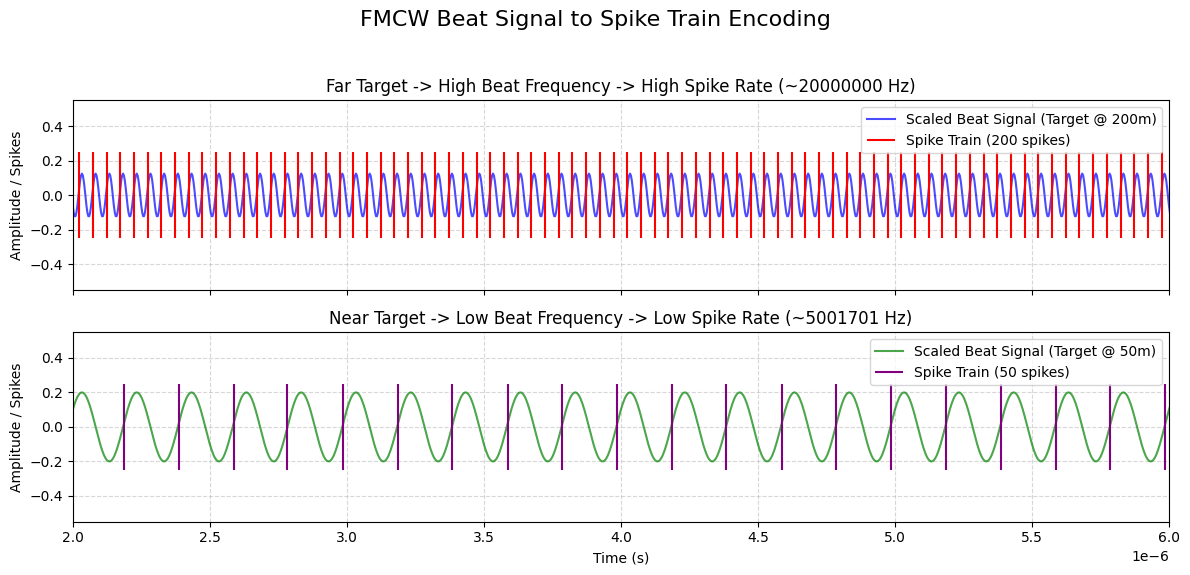

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Minimal Setup to Generate a Beat Signal ---
# (Simplified from your original FMCW code)

# --- Parameters ---
c = 3e8                        # Speed of light (m/s)
fc = 77e9                      # Carrier frequency (Hz)
bw = 150e6                     # Bandwidth
T_chirp = 10e-6                # Chirp duration (s)
k = bw / T_chirp               # Chirp rate (slope)
fs = 2 * bw                    # Sample rate (Hz)

# --- Time vector ---
t = np.arange(0, T_chirp, 1/fs)
n_samples = len(t)

# --- Generate Tx Chirp ---
tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase)

def simulate_beat_signal(target_range):
    """
    Generates a single, clean (no-noise) beat signal
    for a single target at a given range.
    """
    # Calculate time delay
    tau = (2 * target_range) / c

    # Create the delayed time vector
    t_rx = t - tau

    # Generate this target's reflected signal
    rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
    Rx = np.exp(1j * rx_phase)

    # Apply basic attenuation
    att = 1 / (target_range**2) # Simplified attenuation

    # Mix the total received signal with the transmitted
    # This is the "beat frequency" signal
    Mix_signal = Tx * np.conj(Rx * att)

    return Mix_signal

# --- 2. The SNN Encoder (Zero-Crossing Neuron) ---

def encode_zero_crossings(signal):
    """
    Generates spike indices at every positive-going zero-crossing.

    Input:
    signal (1D np.array): The analog signal (e.g., real part of beat signal)

    Returns:
    spike_indices (1D np.array): The array indices where spikes occurred.
    """

    # We are looking for the point where:
    # signal[i-1] < 0   (The signal was negative)
    #   AND
    # signal[i] >= 0  (The signal is now positive or zero)

    # We can do this very fast in NumPy by comparing the signal
    # with a version of itself shifted by one position.

    s_t_minus_1 = signal[:-1] # All elements except the last
    s_t = signal[1:]         # All elements except the first

    # Find all indices 'i' where the condition is True
    # np.where returns a tuple, we take the first element [0]
    indices = np.where((s_t_minus_1 < 0) & (s_t >= 0))[0]

    # We add 1 because the indices are from the 's_t' array,
    # which starts at the original signal's index 1.
    return indices + 1

# --- 3. Run the Simulation and Compare ---

# --- DEMO A: Far Target (High Frequency Beat) ---
target_range_A = 200 # meters
beat_signal_A = simulate_beat_signal(target_range_A)
print('mix_mat',beat_signal_A)

# **IMPORTANT**: We use the *real part* of the complex signal.
# The real part is a simple cosine wave, perfect for this.
real_signal_A = np.real(beat_signal_A)
print('real_mix_mat',real_signal_A)

# Encode the signal into spikes
spike_indices_A = encode_zero_crossings(real_signal_A)
print('spike_indices',spike_indices_A)
# Get the actual *time* of each spike
spike_times_A = t[spike_indices_A]
print('spike_times',spike_times_A)
# Calculate the average spike rate
avg_rate_A = 1 / np.mean(np.diff(spike_times_A))

print(f"--- Target A (Far: {target_range_A}m) ---")
print(f"Beat Frequency: {k * (2*target_range_A/c):.2f} Hz")
print(f"Generated {len(spike_times_A)} spikes.")
print(f"Average Spike Rate: {avg_rate_A:.2f} Hz\n")


# --- DEMO B: Near Target (Low Frequency Beat) ---
target_range_B = 50 # meters
beat_signal_B = simulate_beat_signal(target_range_B)
real_signal_B = np.real(beat_signal_B)

# Encode the signal into spikes
spike_indices_B = encode_zero_crossings(real_signal_B)
spike_times_B = t[spike_indices_B]
avg_rate_B = 1 / np.mean(np.diff(spike_times_B))

print(f"--- Target B (Near: {target_range_B}m) ---")
print(f"Beat Frequency: {k * (2*target_range_B/c):.2f} Hz")
print(f"Generated {len(spike_times_B)} spikes.")
print(f"Average Spike Rate: {avg_rate_B:.2f} Hz\n")

# --- 4. Visualize the Results ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle("FMCW Beat Signal to Spike Train Encoding", fontsize=16)

# --- Plot A: Far Target ---
ax1.plot(t, 5000*real_signal_A, label=f'Scaled Beat Signal (Target @ {target_range_A}m)', color='blue', alpha=0.7)
# Use eventplot to show the discrete spike events
ax1.eventplot(spike_times_A, lineoffsets=0, linelengths=0.5,
              color='red', label=f'Spike Train ({len(spike_times_A)} spikes)')
ax1.set_title(f"Far Target -> High Beat Frequency -> High Spike Rate (~{avg_rate_A:.0f} Hz)")
ax1.set_ylabel("Amplitude / Spikes")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Plot B: Near Target ---
ax2.plot(t, 500*real_signal_B, label=f'Scaled Beat Signal (Target @ {target_range_B}m)', color='green', alpha=0.7)
ax2.eventplot(spike_times_B, lineoffsets=0, linelengths=0.5,
              color='purple', label=f'Spike Train ({len(spike_times_B)} spikes)')
ax2.set_title(f"Near Target -> Low Beat Frequency -> Low Spike Rate (~{avg_rate_B:.0f} Hz)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude / Spikes")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)
plt.xlim(2e-6, 6e-6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# SNN Training - Near vs Far Classification

In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import functional as SF
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from snntorch import surrogate
import math, time

In [ ]:
# --- 1. Data Generation ---

# --- Parameters ---
c = 3e8
fc = 77e9
bw = 150e6
T_chirp = 10e-6
k = bw / T_chirp
fs = 2 * bw
t = np.arange(0, T_chirp, 1/fs)
n_samples = len(t)
tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase)

# --- Data simulation function ---
def generate_sample(batch_size):
    """
    Generates a batch of beat signals and corresponding labels.
    """
    # Create empty tensors to store the data
    # Shape: (batch_size, num_timesteps)
    data_tensor = torch.zeros((batch_size, n_samples))
    # Shape: (batch_size)
    label_tensor = torch.zeros((batch_size), dtype=torch.long)

    for i in range(batch_size):
        # Create a random target
        # 50% chance of "Near" (25-100m)
        # 50% chance of "Far" (125-200m)
        if np.random.rand() > 0.5:
            target_range = np.random.uniform(125, 200)
            label = 1  # "Far"
        else:
            target_range = np.random.uniform(25, 100)
            label = 0  # "Near"

        # --- Simulate the beat signal ---
        tau = (2 * target_range) / c
        t_rx = t - tau
        rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
        Rx = np.exp(1j * rx_phase)
        Mix_signal = Tx * np.conj(Rx) # Simplified (no noise/atten)

        # Use the real part as the input signal
        real_signal = np.real(Mix_signal)

        # Store in tensors
        data_tensor[i] = torch.tensor(real_signal, dtype=torch.float)
        label_tensor[i] = torch.tensor(label, dtype=torch.long)

    # Reshape data for snntorch: (batch_size, num_timesteps, 1 input feature)
    data_tensor = data_tensor.unsqueeze(2)

    return data_tensor, label_tensor


Device: cuda
Training...
Epoch 01 | loss=0.6654 | mean_spike=0.270
Epoch 02 | loss=0.6514 | mean_spike=0.445
Epoch 03 | loss=0.6381 | mean_spike=0.347
Epoch 04 | loss=0.6240 | mean_spike=0.345
Epoch 05 | loss=0.6219 | mean_spike=0.341
Epoch 06 | loss=0.6202 | mean_spike=0.331
Epoch 07 | loss=0.6160 | mean_spike=0.306
Epoch 08 | loss=0.6164 | mean_spike=0.331
Epoch 09 | loss=0.6121 | mean_spike=0.320
Epoch 10 | loss=0.6150 | mean_spike=0.313
Epoch 11 | loss=0.6140 | mean_spike=0.320
Epoch 12 | loss=0.6115 | mean_spike=0.308
Training complete.
Test accuracy: 78.52%

Generating loss plot...


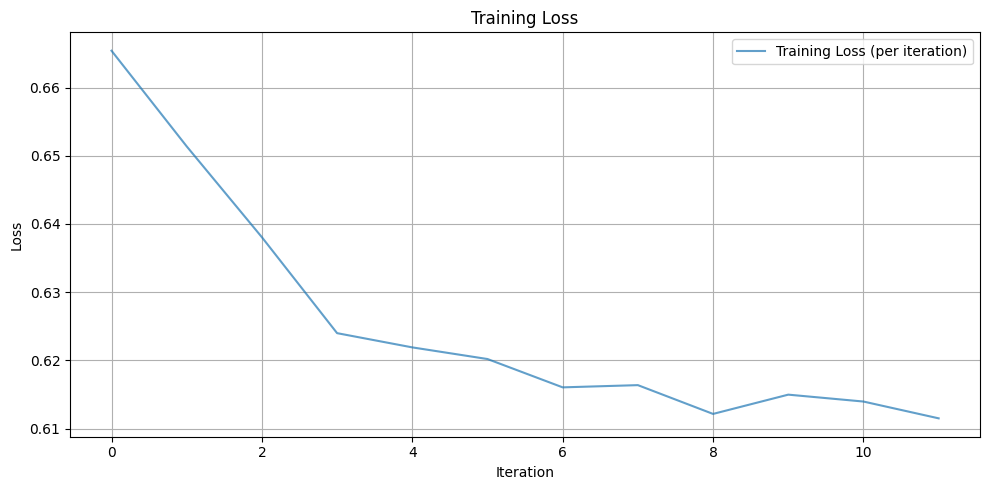

In [ ]:
# --- Imports ---


device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Preprocess: decimate + normalize (+ optional AWGN) ---
def preprocess_batch(x, decim=20, add_awgn=True, snr_db_range=(10, 25)):
    """
    x: [B, T, 1] float
    returns: [B, T', 1]
    """
    B, T, C = x.shape
    # [B, 1, T] for 1D ops
    x = x.permute(0, 2, 1)

    # simple average-pool decimation
    x = F.avg_pool1d(x, kernel_size=decim, stride=decim)  # [B,1,T']

    # per-sample normalization over time
    mean = x.mean(dim=2, keepdim=True)
    std = x.std(dim=2, keepdim=True).clamp_min(1e-6)
    x = (x - mean) / std

    # optional light AWGN augmentation (train mode can toggle this)
    if add_awgn:
        B, C, Tp = x.shape
        # choose an SNR per sample
        snr_db = torch.empty(B, 1, 1, device=x.device).uniform_(*snr_db_range)
        snr = 10 ** (snr_db / 10)
        sig_pow = (x**2).mean(dim=2, keepdim=True)  # ~1 after norm, but compute anyway
        noise_pow = sig_pow / snr
        noise = torch.randn_like(x) * noise_pow.sqrt()
        x = x + noise

    # back to [B, T', 1]
    x = x.permute(0, 2, 1)
    return x

# Choose decimation to target ~150 steps from 3000
D = 20

# --- SNN model (time-major loop) ---
class BeatSNN(nn.Module):
    def __init__(self, in_dim=1, hidden=64, beta=0.995, threshold=0.75):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=threshold,
                              spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(hidden, 2)
        self.lif2 = snn.Leaky(beta=beta, threshold=threshold,
                              spike_grad=surrogate.fast_sigmoid())

        # Good inits
        nn.init.kaiming_normal_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        """
        x: [B, T', 1]
        returns spk_out: [T', B, 2]
        """
        B, T, _ = x.shape
        # init states for this batch on the right device
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk_rec = []
        for t in range(T):
            h1 = self.fc1(x[:, t, :])
            s1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(s1)
            s2, mem2 = self.lif2(h2, mem2)
            spk_rec.append(s2)
        return torch.stack(spk_rec, dim=0)  # [T', B, 2]

# --- Training setup ---
net = BeatSNN().to(device)
opt = torch.optim.Adam(net.parameters(), lr=2e-3)
loss_fn = SF.ce_rate_loss()
grad_clip = 1.0

num_epochs = 12
batches_per_epoch = 100
batch_size = 64

print(f"Device: {device}")
print("Training...")

loss_hist = []
for epoch in range(1, num_epochs + 1):
    net.train()
    running = 0.0

    for _ in range(batches_per_epoch):
        # 1) synth batch from your generator
        data, targets = generate_sample(batch_size)
        data = data.to(device)           # [B,T,1]
        targets = targets.to(device)
        # 2) preprocess
        data = preprocess_batch(data, decim=D, add_awgn=True)
        # 3) forward
        spk_rec = net(data)              # [T',B,2]
        # 4) loss
        loss = loss_fn(spk_rec, targets)
        running += loss.item()
        # 5) step
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

    avg = running / batches_per_epoch
    loss_hist.append(avg)

    # quick spike-rate sanity: mean spikes per time/neuron
    with torch.no_grad():
        spk_mean = spk_rec.float().mean().item()
    print(f"Epoch {epoch:02d} | loss={avg:.4f} | mean_spike={spk_mean:.3f}")

print("Training complete.")

# --- Eval ---
net.eval()
with torch.no_grad():
    test_data, test_targets = generate_sample(1024)
    test_data = test_data.to(device)
    test_targets = test_targets.to(device)

    test_data = preprocess_batch(test_data, decim=D, add_awgn=False)  # no noise in eval

    spk = net(test_data)                 # [T',B,2]
    rates = spk.sum(dim=0)               # [B,2]
    pred = rates.argmax(dim=1)
    acc = (pred == test_targets).float().mean().item()

print(f"Test accuracy: {acc*100:.2f}%")

print("\nGenerating loss plot...")
fig = plt.figure(figsize=(10, 5))

# Plot training loss (per iteration)
plt.plot(loss_hist, label="Training Loss (per iteration)", alpha=0.7)

# Calculate x-axis coordinates for test loss (at the end of each epoch)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Starting training...
Epoch 1/20, Average Loss: 0.6770
Epoch 2/20, Average Loss: 0.6654
Epoch 3/20, Average Loss: 0.6605
Epoch 4/20, Average Loss: 0.6552
Epoch 5/20, Average Loss: 0.6337
Epoch 6/20, Average Loss: 0.6222
Epoch 7/20, Average Loss: 0.6245
Epoch 8/20, Average Loss: 0.6206
Epoch 9/20, Average Loss: 0.6171
Epoch 10/20, Average Loss: 0.6208
Epoch 11/20, Average Loss: 0.6079
Epoch 12/20, Average Loss: 0.6152
Epoch 13/20, Average Loss: 0.6111
Epoch 14/20, Average Loss: 0.6087
Epoch 15/20, Average Loss: 0.6002
Epoch 16/20, Average Loss: 0.5952
Epoch 17/20, Average Loss: 0.5923
Epoch 18/20, Average Loss: 0.5987
Epoch 19/20, Average Loss: 0.5947
Epoch 20/20, Average Loss: 0.5971
Training complete!
Testing model...
Test Accuracy: 83.01%

Generating loss plot...


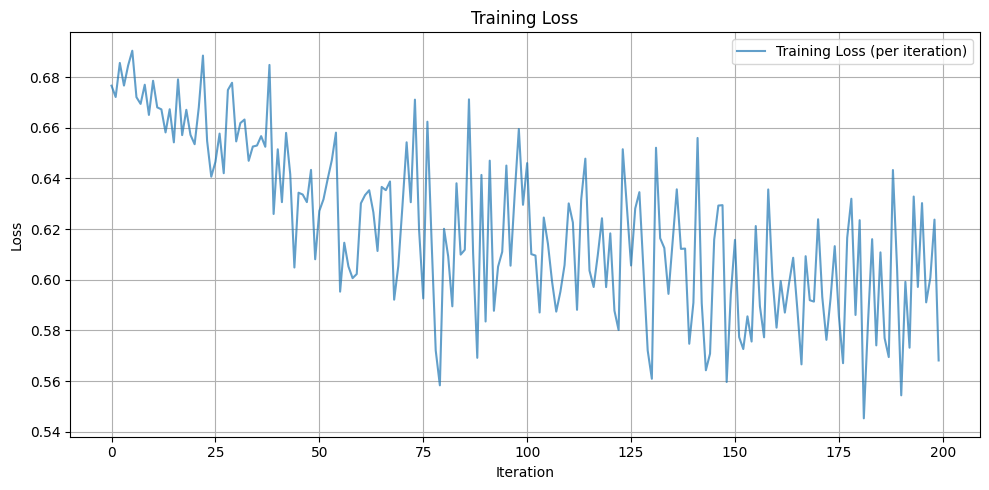

In [ ]:
# --- 2. Define the SNN Model ---
# We'll use a simple 2-layer network:
# Input(1) -> Linear(10) -> LIF(10) -> Linear(2) -> LIF(2)

def preprocess_batch(x, decim=20):
    """
    x: [B, T, 1] float
    returns: [B, T', 1]
    """
    B, T, C = x.shape
    # [B, 1, T] for 1D ops
    x = x.permute(0, 2, 1)
    # simple average-pool decimation
    x = F.avg_pool1d(x, kernel_size=decim, stride=decim)  # [B,1,T']
    # per-sample normalization over time
    mean = x.mean(dim=2, keepdim=True)
    std = x.std(dim=2, keepdim=True).clamp_min(1e-6)
    x = (x - mean) / std
    # back to [B, T', 1]
    x = x.permute(0, 2, 1)
    return x

class SNNModel(nn.Module):
    def __init__(self, beta=0.995,threshold=0.5, hidden=64): # beta = membrane potential decay rate
        super().__init__()

        # Define layers
        self.fc1 = nn.Linear(1, hidden)
        self.lif1 = snn.Leaky(beta=beta,threshold = threshold) # Leaky Integrate-and-Fire neuron
        self.fc2 = nn.Linear(hidden, 2)     # 2 outputs: one for "Near", one for "Far"
        self.lif2 = snn.Leaky(beta=beta,threshold = threshold)
        nn.init.kaiming_normal_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)


    def forward(self, x):
        # Initialize hidden states (membrane potential) at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Store output spikes over time
        spk2_rec = []

        # Time-step loop (snntorch processes data one step at a time)
        for step in range(x.size(1)): # Iterate over the actual number of time steps in the preprocessed data
            cur1 = self.fc1(x[:, step, :]) # Input -> Linear
            spk1, mem1 = self.lif1(cur1, mem1) # -> LIF
            cur2 = self.fc2(spk1) # -> Linear
            spk2, mem2 = self.lif2(cur2, mem2) # -> LIF

            spk2_rec.append(spk2) # Store output spike

        # Stack the recorded spikes
        spk2_rec = torch.stack(spk2_rec)

        # Return the full spike history over time for each output neuron
        # Shape: (num_timesteps, batch_size, num_classes)
        return spk2_rec

# --- 3. The Training Loop ---
loss_hist = []

# Instantiate the model
net = SNNModel().to("cuda") # Use "cuda" if available
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# **Use snntorch's special rate-based Cross Entropy Loss**
# This loss is perfect for our goal.
loss_fn = SF.ce_rate_loss()

num_epochs = 20
num_iters = 10 # Batches per epoch

print("Starting training...")

for epoch in range(num_epochs):
    avg_loss = 0
    for i in range(num_iters):

        # 1. Generate a batch of data
        data, targets = generate_sample(batch_size=64)
        data = data.to("cuda")
        targets = targets.to("cuda")
        data = preprocess_batch(data)

        # 2. Forward pass
        net.train()
        spk_rec = net(data) # This is the total spike count

        # 3. Calculate loss
        loss = loss_fn(spk_rec, targets)
        avg_loss += loss.item()

        loss_hist.append(loss.item())

        # 4. Optimizer and backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss / num_iters:.4f}")

print("Training complete!")

# --- 4. Test the Trained Model ---

print("Testing model...")
# Generate one final batch for testing
test_data, test_targets = generate_sample(batch_size=1024)
test_data = test_data.to("cuda")
test_targets = test_targets.to("cuda")
test_data = preprocess_batch(test_data)

# Run the test batch through the network (no training)
net.eval()
test_spk_rec = net(test_data)

# **Get the final prediction**
# We sum spikes over time to get the rate for prediction
test_spk_out = torch.sum(test_spk_rec, dim=0)

# We just check which output neuron spiked the most
_, predicted_labels = test_spk_out.max(dim=1) # max over outputs (dim 1)

# Compare with targets
correct = (predicted_labels == test_targets).sum().item()
accuracy = correct / test_targets.size(0)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

# --- 5. Plotting ---
print("\nGenerating loss plot...")
fig = plt.figure(figsize=(10, 5))

# Plot training loss (per iteration)
plt.plot(loss_hist, label="Training Loss (per iteration)", alpha=0.7)

# Calculate x-axis coordinates for test loss (at the end of each epoch)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pulse Radar

Processing pulses with Matched Filter...
Processing complete.
Detected STRONGEST target at:
  Range:    800.00 m
  Velocity: -9.59 m/s


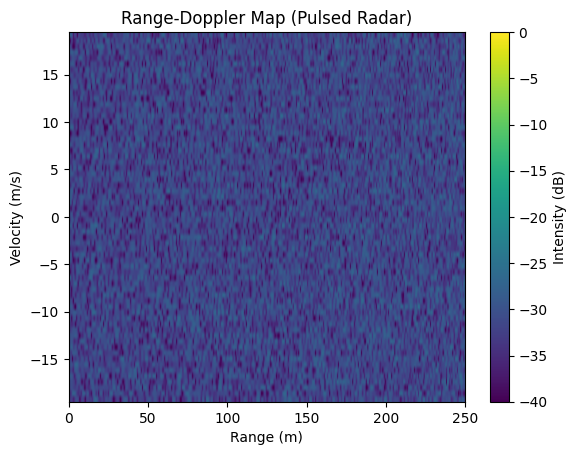

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate # Using Scipy's correlate is easier

# --- Helper Function for AWGN (same as before) ---
def awgn(signal, snr_db, measured='measured'):
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_std_dev = np.sqrt(noise_power / 2.0)
    noise = (np.random.normal(0, noise_std_dev, signal.shape) +
             1j * np.random.normal(0, noise_std_dev, signal.shape))
    return signal + noise

# --- Parameters ---
c = 3e8                        # Speed of light (m/s)
fc = 77e9                      # Carrier frequency (Hz)
lambda_ = c / fc               # Wavelength (m)

# --- Chirp Burst parameters ---
bw = 150e6                     # Bandwidth
T_pulse = 10e-6                # **RENAMED**: Pulse duration (s)
k = bw / T_pulse               # Chirp rate (slope)
fs = 2 * bw                    # Sample rate (Hz)

# --- Frame parameters for velocity ---
n_pulses = 64                  # **RENAMED**: Number of pulses in a frame
PRI = 5 * T_pulse              # **NEW**: Pulse Repetition Interval (time from one pulse to the next)
                               # Must be > T_pulse. This gives a 20% duty cycle.
T_frame = PRI * n_pulses       # Total frame time

# --- Scenario parameters (same) ---
target_range = np.array([200, 75,  50])
target_vel = np.array([20,  -15, 10])
target_rcs = np.array([10,   0.8, 0.5])
n_targets = len(target_range)

# --- Generate Tx Burst Signal ---
t = np.arange(0, T_pulse, 1/fs)     # Time vector for ONE pulse
n_samples = len(t)                  # Number of samples per pulse

tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase) # This is our "chirp burst"

# --- Simulate Pulse Frame ---
# This matrix will store the RAW received signal for each pulse
# In FMCW, this stored the "Mix" signal. Here, it stores the full echo.
Pulse_matrix = np.zeros((n_pulses, n_samples), dtype=complex)

for i in range(n_pulses): # Loop for each pulse

    Rx_total = np.zeros(n_samples, dtype=complex)
    # **CHANGED**: Time is now based on the slower PRI
    time_at_pulse_start = i * PRI

    # iterate through each target
    for j in range(n_targets):

        # Get this target's properties
        r0 = target_range[j]
        v0 = target_vel[j]

        # Calculate this target's current range
        current_range = r0 + v0 * time_at_pulse_start

        # Calculate time delay for this target
        tau = (2 * current_range) / c

        # Create the delayed time vector
        t_rx = t - tau

        # Generate this target's reflected signal phase
        # (This simulates the full RF echo)
        rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
        Rx_j = np.exp(1j * rx_phase)

        # Apply attenuation based on range and RCS
        att = target_rcs[j] / (current_range**4)

        # Add this target's signal to the total
        Rx_total = Rx_total + (att * Rx_j)

    # Add noise
    Rx_noisy = awgn(Rx_total, 10, 'measured')

    # **--- KEY CHANGE ---**
    # We NO LONGER mix. We store the raw received echo.
    # The receiver is "listening" for a duration of T_pulse.
    Pulse_matrix[i, :] = Rx_noisy

# --- Process the Signal (Matched Filter + Doppler FFT) ---

# **NEW**: Create the Range-Doppler Matrix
# We will fill this by processing one pulse at a time
RDM = np.zeros((n_pulses, n_samples), dtype=complex)

print("Processing pulses with Matched Filter...")
# --- 1. Matched Filter (for Range) ---
# This replaces the "Range FFT" from the FMCW code.
for i in range(n_pulses):
    # Get the raw received signal for this pulse
    Rx_pulse_i = Pulse_matrix[i, :]

    # Correlate the received signal with the transmitted pulse (Tx)
    # This "compresses" the echo and finds *when* it arrived.
    # 'same' mode keeps the output the same size as the input
    # 'fft' method is fast
    mf_output = correlate(Rx_pulse_i, Tx, mode='same', method='fft')
    RDM[i, :] = mf_output

print("Processing complete.")

# --- 2. Doppler FFT (for Velocity) ---
# This part is the same as before, but runs on the Matched Filter output
n_fft_vel = int(2**np.ceil(np.log2(n_pulses)))
rdm_final = np.fft.fftshift(np.fft.fft(RDM, n_fft_vel, axis=0), axes=0)


# --- Create Axes for Plotting ---

# **CHANGED**: The Range axis is now based on TIME-OF-FLIGHT, not beat frequency.
# The axis of our matched filter output is time.
time_axis = t
range_axis = (time_axis * c) / 2

# **CHANGED**: The Doppler axis is now based on the PRI, not T_chirp
fs_doppler = 1 / PRI  # Max Doppler is set by how often we send a pulse
doppler_freq_axis = np.linspace(-fs_doppler/2, fs_doppler/2, n_fft_vel)
vel_axis = (doppler_freq_axis * lambda_) / 2

# --- Visualize the Range-Doppler Map (RDM) ---
plt.figure()

# We plot the full RDM, not just half
rdm_plot = np.abs(rdm_final)
rdm_db = 10 * np.log10(rdm_plot / np.max(rdm_plot)) # Normalize for better plotting

# Use imshow to plot.
plt.imshow(rdm_db,
           extent=[range_axis[0], range_axis[-1], vel_axis[0], vel_axis[-1]],
           aspect='auto',
           origin='lower',
           vmin=-40) # Set a minimum dB level to reduce background noise

plt.title('Range-Doppler Map (Pulsed Radar)')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Intensity (dB)')
plt.xlim(0, 250)
# Adjust ylim to see targets, as max unambiguous velocity is now different
max_vel = (fs_doppler / 2 * lambda_) / 2
plt.ylim(-max_vel, max_vel)


# --- Find the Peak - only finds strongest target ---
max_val = np.max(rdm_plot)
max_idx_flat = np.argmax(rdm_plot)
vel_idx, range_idx = np.unravel_index(max_idx_flat, rdm_plot.shape)

print('Detected STRONGEST target at:')
print(f'  Range:    {range_axis[range_idx]:.2f} m')
print(f'  Velocity: {vel_axis[vel_idx]:.2f} m/s')

# Display the plot
plt.show()